## Chargement des packages

In [18]:
import lsst.daf.persistence as dp
import lsst.afw.display as display
import lsst.afw.display.rgb as rgb
import lsst.geom as geom

import numpy as np
import os, glob
import math

from optparse import OptionParser

import mysql
from mysql.connector import Error

import pandas as pd
from tifffile import imread, imwrite

import matplotlib.cm as cm
from matplotlib import pylab as plt

## Définition des fonctions

In [19]:
def checkPatch(tract, patch, butler):
    # Detect incomplete patches located at the border of the DC2 footprint
    # Detection is based on the number of detected sources
    goodImage = True
    patchName = str(patch[0]) + ',' + str(patch[1])
    dataId = {'tract':tract, 'patch':patchName, 'filter':'r'}
    try:
        src = butler.get('deepCoadd_forced_src', dataId=dataId)
    except Exception as msg:
        print(msg)
        goodImage = False

    if goodImage and len(src) < 10000:
        goodImage = False
        print("Incomplete image detected for tract={} - patch={}".format(tract, patch))

    return goodImage

In [20]:
def getHalos(raMin, raMax, decMin, decMax, zMax, massMin):
    # Initialize connection to qserv
    conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040) 
    cursor = conn.cursor(dictionary=True, buffered=True) 

    # Buil SQL query
    query = "SELECT data.coord_ra, data.coord_dec, data.halo_mass, data.redshift, data.Mag_true_z_lsst_z0, data.is_central, data.halo_id "
    query += "FROM cosmoDC2_v1_1_4_image.data as data "
    query += f"WHERE scisql_s2PtInBox(data.coord_ra, data.coord_dec, {raMin}, {decMin}, {raMax}, {decMax}) = 1 "
    query += f"AND data.halo_mass>{massMin} AND data.redshift<{zMax} "
    query += ";"

    #Execute Qserv query et get result in a panda dataframe
    tab = pd.read_sql_query(query,conn)

    return tab

In [21]:
def getFullImage(butler, tract, patch, innerBbox):
    # Get the 6 band image corresponding to a given tract, patch
    patchName = str(patch[0]) + ',' + str(patch[1])
    dataId = {'tract':tract, 'patch':patchName}
    im = {}
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    isBad = False
    for f in filters:
        dataId['filter'] = f
        try:
            exp = butler.get('deepCoadd', dataId=dataId).getMaskedImage()[innerBbox]
        except Exception as msg:
            print(msg)
            isBad = True
            break

        im[f] = exp.getImage().getArray()
        # We need to keep the reference coordinates X0, Y0 to convert image coordinates into natural CCD coordinates
        if f == 'r':
            X0 = exp.getX0()
            Y0 = exp.getY0()

    if not isBad:
        #Images have pixels with negative values so we add a pedestal in order to have only positive pixels 
        minVal = np.min([np.min(im[f]) for f in filters])
        if minVal < 0:
            pedestal = math.ceil(-minVal)
        else:
            pedestal = 0

        fullImage = np.dstack([im[f] + pedestal for f in filters])

        # If everything has been done correctly the overlap region should have been removed around
        # the patch and the image should be 4000x4000 pixels
        # If not, just print out a warning
        numPix = im['r'].shape[1]
        if numPix != 4000:
            print("Unexpected number of pixels in image {}".format(numPix))
    else:
        fullImage = [],
        X0 = -99
        Y0 = -99

    return fullImage, X0, Y0, isBad

In [22]:
def getSkyBbox(halos, minGal):
    # Determine bounding box containing all the halo members

    # The following 102 halo_ids correspond to badly allocated halo fragments resulting in unphysical overlapping halos. They need to be ignored 
    bad_halos = [6000141293, 360200141293, 796200182347, 211200182347, 43900177421, 105200177421, 770300055331, 889800055331, 371700158392, 
                 188200158392, 35700164347, 147900164347, 1594400179300, 1770700179300, 46800066421, 203600066421, 700156401, 177000156401, 
                 1024800140307, 755300140307, 79400164355, 377800164355, 90200163338, 96600163338, 719800156331, 653000156331, 167900142421, 
                 55300142421, 192400137401, 101900137401, 455300072355, 385900072355, 237200108411, 53800108411, 182200154373, 61400154373, 
                 292700141373, 536900141373, 281100128382, 114300128382, 1986200129293, 1148100129293, 523900115382, 175100115382, 587300129307, 
                 1582600129307, 499100113382, 23700113382, 715300097347, 486600097347, 336500043382, 28600043382, 1220300114293, 210600114293, 
                 757400098338, 562900098338, 445500110355, 301800110355, 146000071293, 966700071293, 727900096338, 249600096338, 1227200113293, 
                 1228400113293, 845000093300, 411000093300, 199400099365, 107400099365, 302200046323, 1117200046323, 149400078392, 144400078392, 
                 519000099331, 398000099331, 582700080355, 273300080355, 132700048382, 289700048382, 386000046382, 101100046382, 1862600043293, 
                 953500043293, 467300072365, 357100072365, 181800048382, 514100048382, 1144700047338, 80000047338, 145900047347, 177600047347, 
                 564400033323, 397900033323, 1210400078293, 182500078293, 1018500071307, 530600071307, 438000069307, 138300069307, 714200041331, 
                 1016500041331, 175900046323, 1103000046323]

    reject = False
    z = halos.groupby(['halo_id'])
    skyBbox = []
    for halo, df in z:
        if len(df) < minGal : # request a minimum number of galaxy members in the halo
            continue
        if halo in bad_halos:
            print("rejected halo: {}".format(halo))
            reject = True
            break
        min = geom.SpherePoint(df.coord_ra.min()*geom.degrees, df.coord_dec.min()*geom.degrees)
        max = geom.SpherePoint(df.coord_ra.max()*geom.degrees, df.coord_dec.max()*geom.degrees)
        #print(halo, df.halo_id.to_list()[0], min, max, df.redshift.to_list()[0], df.halo_mass.to_list()[0]*1.e-14)
        skyBbox.append([halo, min, max])

    return skyBbox, reject

In [23]:
def crop(x):
# crop bounding box coordinates in order to stay within the 0-3999 range
    if (x<0):
        x = 0
    elif (x>3999):
        x = 3999
    return x

## Test fonction affichage (brouillon)

In [24]:
def display_tiff(imageFile, labelFile, red='i', green='r', blue='g'):
    
    filters = ['u', 'g', 'r', 'i', 'z', 'y'] # filters list
    
    # Test des filtres dans la liste
    if not set([red, green, blue]).issubset(set(filters)):
        print("filter(s) selected not in filters list ['u', 'g', 'r', 'i', 'z', 'y']")
        return

    img = imread(imageFile) # Lecture de l'image
    
    numPix = img.shape[0] # Taille de l'image
    if numPix != 4000:
        print("Unexpected number of pixels in image {}".format(numPix))

    # Transformation des donnees en rgb
    rgb_im = rgb.makeRGB(img[:,:,filters.index(red)], img[:,:,filters.index(green)], img[:,:,filters.index(blue)], Q=8, minimum = -0.1, dataRange=1.5, 
                           saturatedPixelValue=100,
                           xSize=None, ySize=None)
    
    colors = cm.Set1(np.linspace(0, 1, 5)) # Definition des couleurs

    # Display Image
    display.setDefaultBackend("matplotlib")
    fig = plt.figure(figsize=(20, 20))
    disp = rgb.displayRGB(rgb_im, show=False)

    # Ouverture des labels si le fichier existe
    try:
        labels = pd.read_csv(labelFile, header=None, sep = " ")
        
        # Ajout des box sur le graphe
        for box, c in zip(labels.iterrows(), colors):
            # Redimensionnement des coordonnees a la taille de l'image
            box =  [i*numPix for i in box[1]]
            X = [box[1], box[1], box[1]+box[3], box[1]+box[3], box[1]]
            Y = [box[2], box[2]+box[4], box[2]+box[4], box[2], box[2]]
            disp.plot(X,Y, color=c)
    except:
            print("No label file found")


## Tests

In [25]:
tract = 4433
patch = (4,4)

### Chargement images issues de annotate pour comparaison

A passer en code si besoin d'utiliser

### Définition des variables

In [26]:
##### Filtres #####
filters = ['u', 'g', 'r', 'i', 'z', 'y'] # filters list

red = 'i'
green = 'r'
blue = 'g'

In [27]:
##### Chargement des fichiers images et labels #####
imageFile = "/sps/lsst/users/boutigny/ML/DC2/images/"+str(tract)+"_"+str(patch[0])+","+str(patch[1])+".tif"
labelFile = "/sps/lsst/users/boutigny/ML/DC2/labels/"+str(tract)+"_"+str(patch[0])+","+str(patch[1])+".txt"

In [28]:
##### Lecture de l'image ####
img = imread(imageFile) # Lecture de l'image

numPix = img.shape[0] # Taille de l'image
if numPix != 4000:
    print("Unexpected number of pixels in image {}".format(numPix))

In [29]:
#### Definir meilleurs parametres #####

In [38]:
##### fixation des paramètres ####
best_Q = 8
best_min = np.max([np.min(img[:,:,filters.index(f)]) for f in filters])
best_dr  = 1.5

In [39]:
##### Transformation des donnees en rgb ####
rgb_im = rgb.makeRGB(img[:,:,filters.index(red)], img[:,:,filters.index(green)], img[:,:,filters.index(blue)], Q = best_Q, minimum = best_min, dataRange = best_dr,
                       xSize=None, ySize=None)

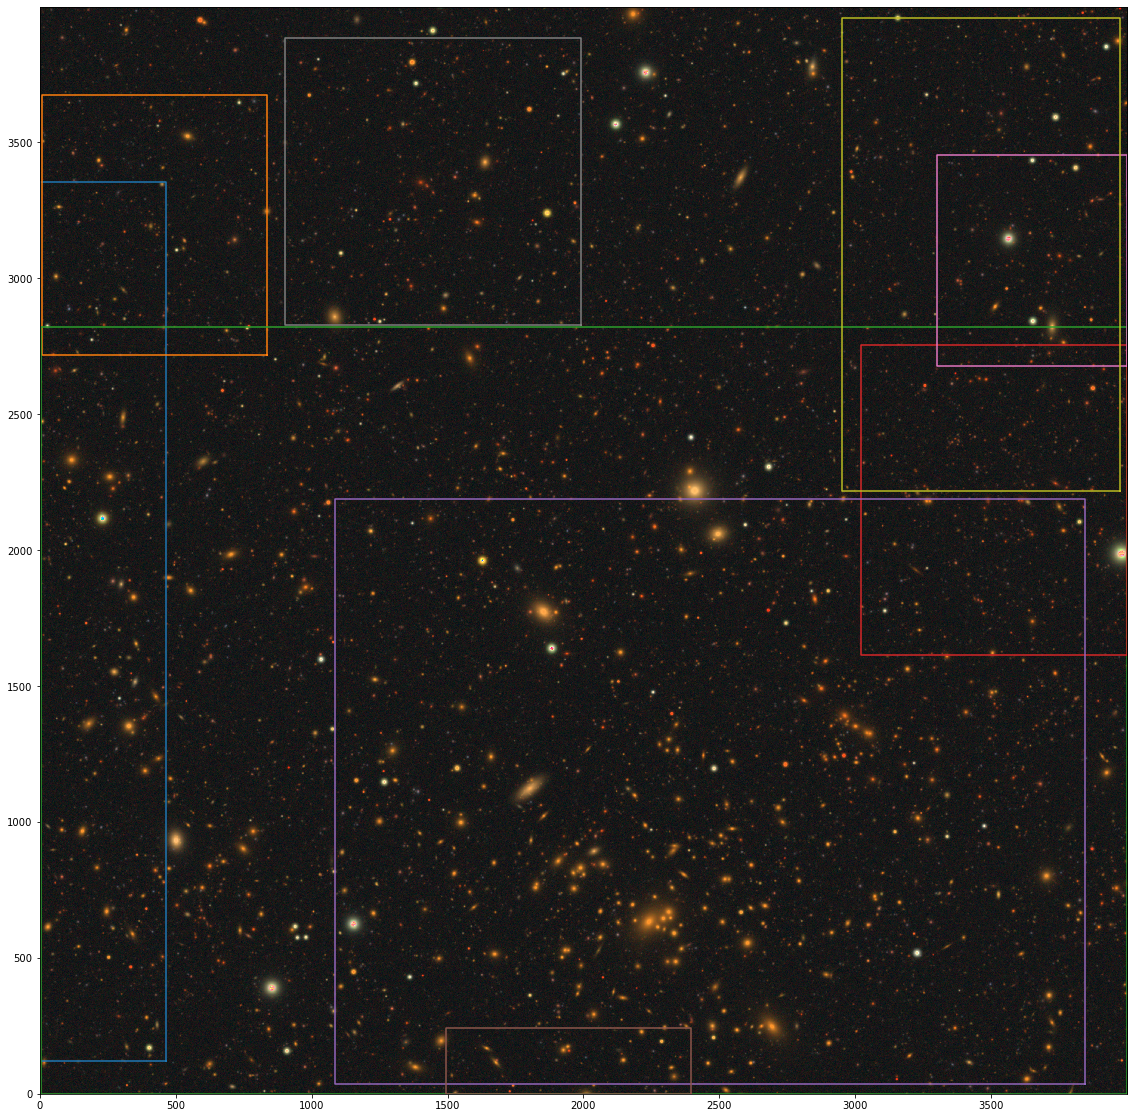

In [40]:
###### Affichage de l'image #####

colors = cm.tab10(np.linspace(0, 1, 10)) # Definition des couleurs

# Display Image
display.setDefaultBackend("matplotlib")
fig = plt.figure(figsize=(20, 20))
disp = rgb.displayRGB(rgb_im, show=False)

# Ouverture des labels si le fichier existe
try:
    labels = pd.read_csv(labelFile, header=None, sep = " ")

    # Ajout des box sur le graphe
    for box, c in zip(labels.iterrows(), colors):
        # Redimensionnement des coordonnees a la taille de l'image
        box =  [i*(numPix-1) for i in box[1]]   
        X = [box[1]+box[3], box[1]+box[3], box[1], box[1], box[3]+box[1]]
        Y = [(numPix-1)-box[2]-box[4], (numPix-1)-box[2], (numPix-1)-box[2], (numPix-1)-box[2]-box[4], (numPix-1)-box[2]-box[4]]
        disp.plot(X,Y, color=c)
except:
        print("No label file found")

In [33]:
print(labels)

   0         1         2         3         4
0  0  0.000000  0.161668  0.115980  0.808251
1  0  0.002022  0.080821  0.206833  0.239771
2  0  0.000873  0.294626  0.999127  0.705374
3  0  0.755940  0.311179  0.244060  0.285065
4  0  0.271159  0.452586  0.690481  0.538274
5  0  0.373494  0.939850  0.225992  0.060150
6  0  0.825629  0.136413  0.174371  0.193667
7  0  0.225364  0.028535  0.272353  0.264079
8  0  0.737762  0.010321  0.256454  0.435281


In [34]:
print(X)
print(Y)

[3975.871390304186, 3975.871390304186, 2950.311905122573, 2950.311905122573, 3975.871390304186]
[2217.038924191809, 3957.7259280760663, 3957.7259280760663, 2217.038924191809, 2217.038924191809]


## Test combinaison paramètres

A passer en code si besoin

## Test nombre amas de galaxie